## Adventurework Försäljningsanalys
### Styfle med analysen:
Denna analys för att undersöka försäljningsdata från AdventureWorks-databasen
för att identifiera mönster inom produktutbud, försäljning över tid, kundbeteenden samt
regionella skillnader.
Målet med analysen är att ge affärsinsikter som kan stödja strategiska beslut gällande sortement, marknadsföring och kundfokus.

In [76]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine, text
from urllib.parse import quote_plus

user = "SA"
password = quote_plus("Salamjan1")
server = 'localhost,1433'
database = 'AdventureWorks2025'
driver = quote_plus("ODBC Driver 17 for SQL server")



connection_string = (
    f"mssql+pyodbc://{user}:{password}@{server}/{database}"
    f"?driver={driver}&Encrypt=yes&TrustServerCertificate=yes"
)

engine = create_engine(connection_string)


try:
   
   with engine.connect() as conn:
        print(conn.execute(text("SELECT 1")).fetchone())
except Exception as e:
    print("Connection failed:", e)

(1,)


C:\Users\zanya\AppData\Local\Temp\ipykernel_9092\4255204508.py:25: SAWarning: Unrecognized server version info '17.0.1000.7'.  Some SQL Server features may not function properly.
  with engine.connect() as conn:


### Visualisering1 Antal produkter per kategori
Hur många produkter ingår i varje kategori?
Vi kopplar samman produkt, Subkategori och huvudkategori, 
vi räknar antalet unika produkter inom varje kategori.

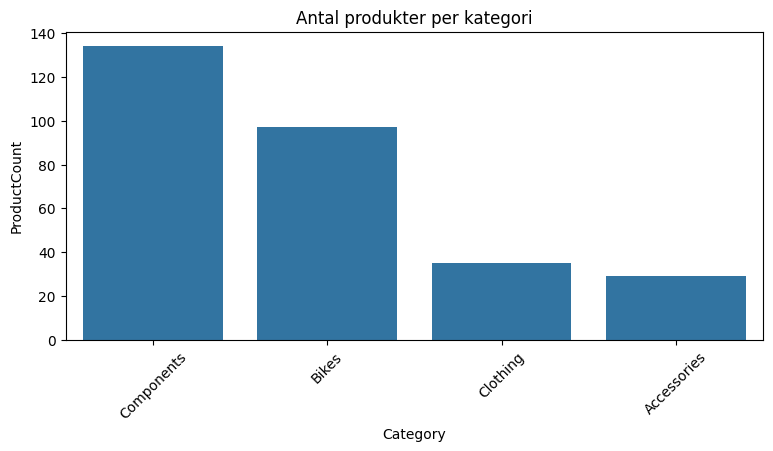

In [77]:
sql_1 = """
SELECT
    pc.Name AS Category,
    COUNT(DISTINCT p.ProductID) AS ProductCount
FROM Production.ProductCategory pc
JOIN Production.ProductSubcategory ps ON pc.ProductCategoryID=ps.ProductCategoryID
JOIN Production.Product p ON ps.ProductSubcategoryID = p.ProductSubcategoryID
GROUP BY pc.Name
ORDER BY ProducTCount DESC
"""
   

df1 = pd.read_sql(sql_1, engine)

plt.figure(figsize=(9,4))
sns.barplot(data=df1, x='Category', y='ProductCount')
plt.title("Antal produkter per kategori")
plt.xticks(rotation=45)
plt.show()



### Visualisering2: Antal prdukter per försäljning.

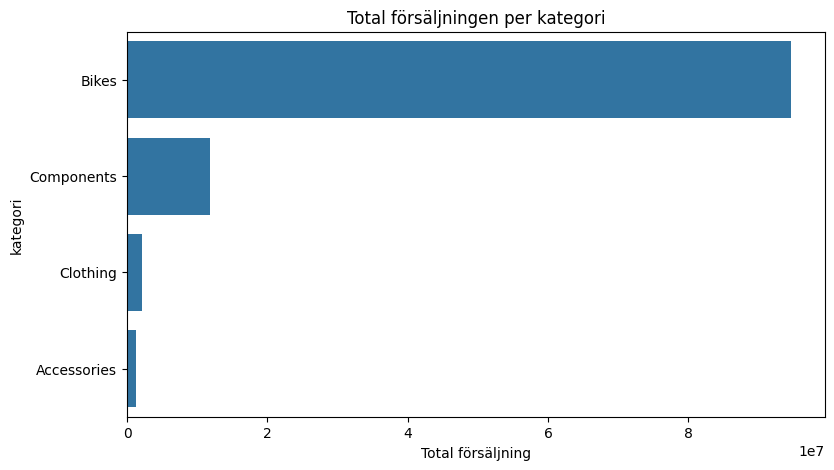

In [78]:
sql_2 = """
SELECT
    pc.Name AS Category,
    SUM(sod.LineTotal) AS Totalsales
FROM Sales.SalesOrderDetail sod
JOIN Production.Product p
    ON sod.ProductID = p.ProductID
JOIN Production.ProductSubcategory ps
    ON p.ProductSubcategoryID = ps.ProductSubcategoryID
JOIN Production.ProductCategory pc
    ON ps.ProductCategoryID = pc.ProductCategoryID

GROUP BY pc.Name
ORDER BY Totalsales DESC
"""

df2 = pd.read_sql(sql_2, engine)

plt.figure(figsize=(9,5))
sns.barplot(
    data=df2, 
    y='Category', 
    x='Totalsales'
    )
plt.title("Total försäljningen per kategori")
plt.xlabel("Total försäljning")
plt.ylabel("kategori")
plt.show()


### Försäljning per månad:

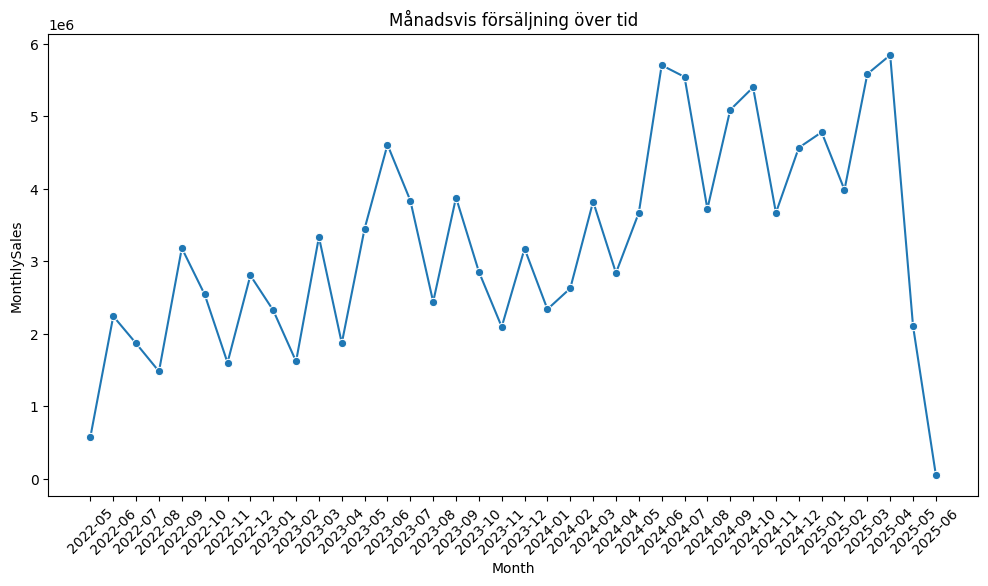

In [79]:
sql_3 = """
SELECT
    FORMAT(OrderDate, 'yyyy-MM') AS Month,
    SUM(TotalDue) AS MonthlySales
FROM Sales.SalesOrderHeader
GROUP BY FORMAT(OrderDate, 'yyyy-MM')
ORDER BY Month ASC;
"""

df3 = pd.read_sql(sql_3, engine)

plt.figure(figsize=(12,6))
sns.lineplot(data=df3, x='Month', y='MonthlySales', marker='o')
plt.title("Månadsvis försäljning över tid")
plt.xticks(rotation=45)
plt.show()

#### Vis 4 försäljning och antal ordrar per år.

In [80]:
sql_4 = """
SELECT
    YEAR(OrderDate) AS Year,
    COUNT(SalesOrderID) AS OrderCount,
    SUM(TotalDue) AS TotalSales
FROM Sales.SalesOrderHeader
GROUP BY YEAR(OrderDate)
ORDER BY Year ASC;
"""
df4 = pd.read_sql(sql_4, engine)
df4_melt = df4.melt(
    id_vars='Year', 
    value_vars=['Sales', 'Orders']
    )
plt.figure(figsize=(8,4))
sns.barplot(
    data=df4_melt, 
    x='År', 
    y='Värde', 
    hue='Varjabel'
    )
plt.title("Årlig försäljning och orderantal")
plt.xlabel("År")
plt.ylabel("Värde") 
plt.show()

KeyError: "The following id_vars or value_vars are not present in the DataFrame: ['Sales', 'Orders']"

### 5. Top 5 produkter

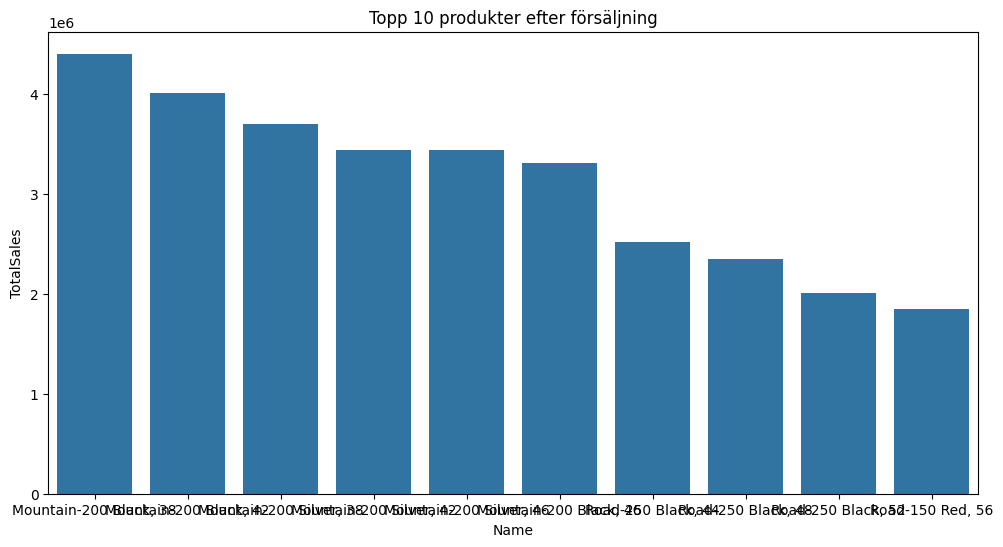

In [ ]:
sql_5 = """
SELECT TOP 10
    p.Name,
    SUM(sod.LineTotal) AS TotalSales
FROM Sales.SalesOrderDetail sod
JOIN Production.Product p ON sod.ProductID = p.ProductID
GROUP BY p.Name
ORDER BY TotalSales DESC
"""
df5 = pd.read_sql(sql_5, engine)
plt.figure(figsize=(12,6))
sns.barplot(data=df5, x='Name', y='TotalSales')
plt.title("Topp 10 produkter efter försäljning")
plt.show()

## 6. Region

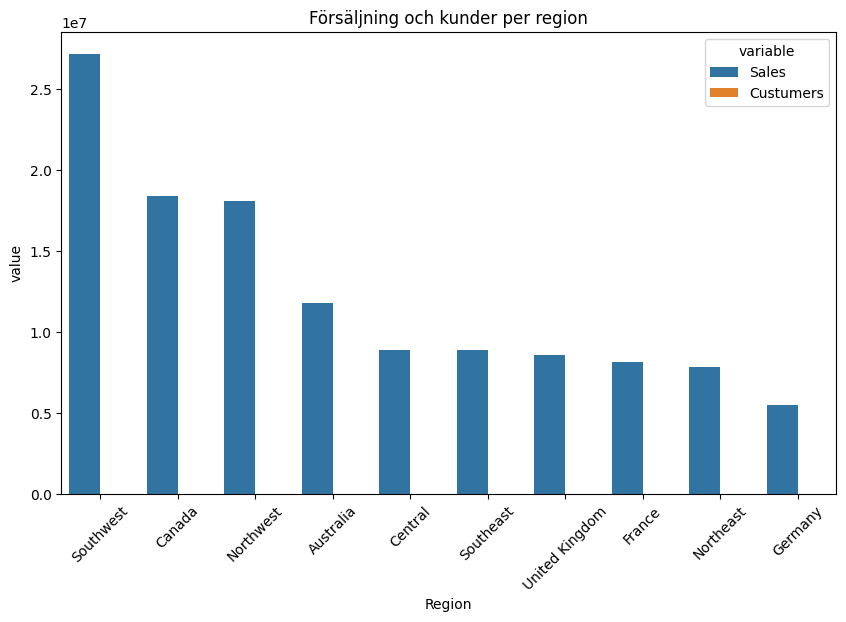

In [ ]:
sql_6 = """

SELECT
    st.Name AS Region,
    SUM(soh.TotalDue) AS Sales,
    COUNT(DISTINCT soh.SalesOrderID) AS Custumers
FROM Sales.SalesOrderHeader soh
    JOIN Sales.Customer c
    ON soh.CustomerID = c.CustomerID
    JOIN Sales.SalesTerritory st
    ON c.TerritoryID = st.TerritoryID
GROUP BY st.Name
ORDER BY Sales DESC
"""

df6 = pd.read_sql(sql_6, engine)

df6 = pd.read_sql(sql_6, engine)

df6_melt = df6.melt(id_vars='Region', value_vars=['Sales', 'Custumers'])
plt.figure(figsize=(10,6))
sns .barplot(data=df6_melt, x='Region', y='value', hue='variable')
plt.xticks(rotation=45)
plt.title("Försäljning och kunder per region")
plt.show()

### 7.Genomsnitt ordervärde:

In [ ]:
sql_7 = """
SELECT
    st.Name AS Region,
    CASE 
        WHEN s.BusinessEntityID IS NULL THEN 'Individual'
        ELSE 'Store'
    END AS CustomerType,
    SUM(soh.TotalDue) / COUNT(soh.SalesOrderID) AS AvgSalesPerOrder
FROM Sales.SalesOrderHeader soh
JOIN Sales.Customer C
    ON soh.CustomerID = c.CustomerID
LEFT JOIN Sales.Store s
    ON c.StoreID = s.BusinessEntityID
 Sales.SalesTerritory st
    ON soh.TerritoryID = st.TerritoryID
GROUP BY st.Name,
    CASE 
        WHEN s.BusinessEntityID IS NULL THEN 'Individual'
        ELSE 'Store'
    END
ORDER BY AvgSalesPerOrder DESC
"""
df7 = pd.read_sql(sql_7, engine)

plt.figure(figsize=(12,6))
sns.barplot(data=df7, x='Region', y='AvgSalesPerOrder', hue='CustomerType')
plt.title("Genomsnittlig försäljning per order efter region och kundtyp")
plt.xticks(rotation=45)
plt.show()

ProgrammingError: (pyodbc.ProgrammingError) ('42000', "[42000] [Microsoft][ODBC Driver 17 for SQL Server][SQL Server]Incorrect syntax near 'Sales'. (102) (SQLExecDirectW)")
[SQL: 
SELECT
    st.Name AS Region,
    CASE 
        WHEN s.BusinessEntityID IS NULL THEN 'Individual'
        ELSE 'Store'
    END AS CustomerType,
    SUM(soh.TotalDue) / COUNT(soh.SalesOrderID) AS AvgSalesPerOrder
FROM Sales.SalesOrderHeader soh
JOIN Sales.Customer C
    ON soh.CustomerID = c.CustomerID
LEFT JOIN Sales.Store s
    ON c.StoreID = s.BusinessEntityID
 Sales.SalesTerritory st
    ON soh.TerritoryID = st.TerritoryID
GROUP BY st.Name,
    CASE 
        WHEN s.BusinessEntityID IS NULL THEN 'Individual'
        ELSE 'Store'
    END
ORDER BY AvgSalesPerOrder DESC
]
(Background on this error at: https://sqlalche.me/e/20/f405)